# Markov Random Fields

Use Markov Random Fields to solve several computer vision problems.

## Image denoising

Implement an image denoising procedure based on Markov Random Fields. Use the clique and energy definitions found in Lecture 5. As optimization strategy, you can implement Iterated Conditional Modes or other algorithm. 

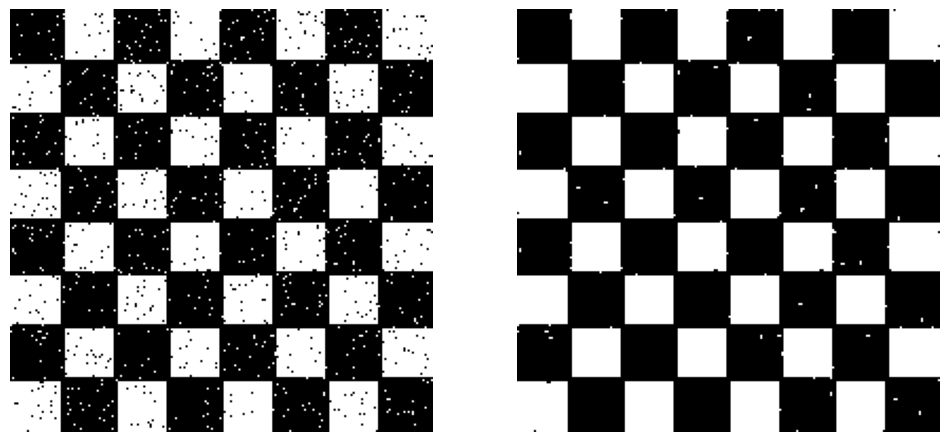

In [8]:
#this strategy takes some minutes to compute (around 3mins)

import matplotlib.pyplot as plt

from skimage import data
from skimage.util import random_noise

import numpy as np

#%matplotlib inline
    
plt.rcParams['figure.figsize'] = (12, 6)

def calculate_graph_energy(X, Y, **kwargs):

    h= kwargs['h']
    beta= kwargs['beta']
    nu= kwargs['nu']
    height= kwargs['height']
    width= kwargs['width']

    sum_xi= np.sum(X)
    sum_xi_yi = np.sum(X[1:-1, 1:-1] * Y[1:-1, 1:-1])

    sum_xi_xj = (np.sum(X[:-1, :] * X[1:, :]) + np.sum(X[:, :-1] * X[:, 1:])) 

    h_term= h*sum_xi
    pairwise_term= -beta*sum_xi_xj
    unary_term= -nu*sum_xi_yi

    graph_energy= h_term + pairwise_term + unary_term
    
    return graph_energy


def node_energy_denoising(X, Y, **kwargs):
    height= kwargs['height']
    width= kwargs['width']

    #selects 1 node at a time, repeat for all nodes
    for i in range(1, height-1):
        for j in range(1, width-1):
            
            X_state1= X.copy() #1
            X_state1[i, j]=1
            
            #calculate energy for state 1
            energy_state1= calculate_graph_energy(X_state1, Y, **kwargs)
        
            X_state2= X.copy()
            X_state2[i, j]= -1 #-1
            

            #calculate energy for state -1
            energy_state2= calculate_graph_energy(X_state2, Y, **kwargs)
        
            if (energy_state1 < energy_state2):
                X= X_state1
        
            else:
                X= X_state2
    
    
    return X


# Note: you can use kwargs to pass optional parameters to functions
# in python. 
def optimization_algorithm(X, Y, **kwargs):

    #repeat until stopping criterion is satisfied
    iterations= kwargs['iterations']


    for iter in range(iterations):
        #print(iter)
        X = node_energy_denoising(X, Y, **kwargs)

    
    return X


img = data.checkerboard().astype(np.float32)
noisy = random_noise(img, 's&p', amount=0.05)
noisy[np.where(noisy==0)] = -1

X = noisy*1

height, width = X.shape

mrf = optimization_algorithm(X, noisy, height=height, width=width, iterations=5, h=1, beta=2, nu=5)

fig, ax = plt.subplots(1,2)
ax[0].imshow(noisy, cmap='binary')
ax[0].axis('off')
ax[1].imshow(mrf, cmap='binary')
ax[1].axis('off')
plt.show()

## Image segmentation

Implement a segmentation procedure to label an image as foreground and background using Markov Random Fields. Use the cliques and energies defined in Lecture 5. You can reuse the minimization algorithm implemented in the previous exercise.

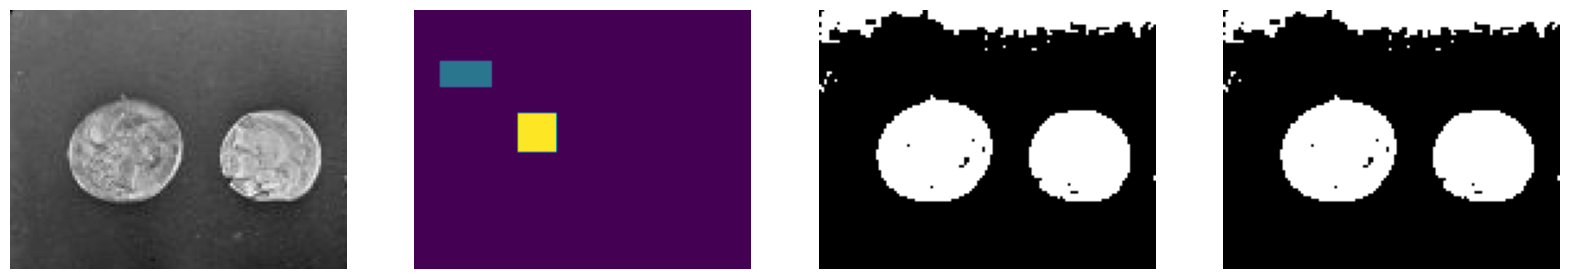

In [6]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.util import random_noise

import numpy as np
#%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 6)

BG_LABEL = 100
FG_LABEL = 255


def calculate_graph_energy(X, Y, i, j, **kwargs):
    labels= kwargs['labels']
    height= kwargs['height']
    width= kwargs['width']

    beta= kwargs['beta']
    sigma= kwargs['sigma']

    dif_up = dif_down = dif_left = dif_right = 0

    #Unary Term
    #unlabeled
    if (labels[i,j]==0):
        #print("Unlabeled")         

        if X[i,j]== 0: #background (state 0)
            unary= Y[i,j]
            
        else: #foreground (state 1)
            unary= (255- Y[i,j])
            
            
   #labeled
    else:
        #print("Labeled")         

        if (X[i,j]==0 and labels[i,j]==100 ):           
            unary= 0
            #print("Label matches (BG)")         
         
        elif (X[i,j]==1 and labels[i,j]==255 ):
            unary= 0
            #print("Label matches (FG)")         

        else:
            unary= 10**10
            #print("Label does not match")         

                           
    #Pairwise Term
    if j > 0:
       dif_up = abs(X[i, j] - X[i, j - 1]) * np.exp(-(Y[i, j] - Y[i, j - 1]) ** 2 / (2 * sigma ** 2))
   
    if j < width - 1:
       dif_down = abs(X[i, j] - X[i, j + 1]) * np.exp(-(Y[i, j] - Y[i, j + 1]) ** 2 / (2 * sigma ** 2))
   
    if i > 0:
       dif_left = abs(X[i, j] - X[i - 1, j]) * np.exp(-(Y[i, j] - Y[i - 1, j]) ** 2 / (2 * sigma ** 2))
   
    if i < height - 1:
       dif_right = abs(X[i, j] - X[i + 1, j]) * np.exp(-(Y[i, j] - Y[i + 1, j]) ** 2 / (2 * sigma ** 2))
       
        
    dif_tot= dif_up+dif_down+dif_left+dif_right
  
    pairwise=beta* dif_tot 

    #Total Graph Energy
    graph_energy= unary+pairwise
            
    return graph_energy

def node_energy_segmentation(X, Y, **kwargs):
    labels= kwargs['labels']
    height= kwargs['height']
    width= kwargs['width']

    #selects 1 node at a time, repeat for all nodes
    for i in range(0, height):
        for j in range(0, width):

            X_state1= X.copy() #state 1: Foreground
            X_state1[i, j]= 1

            X_state2= X.copy() #state 0: Background
            X_state2[i, j]= 0
            
            #calculate energy for state 1 (FG)
            energy_state1= calculate_graph_energy(X_state1, Y, i, j, **kwargs)

            #calculate energy for state 2 (BG)
            energy_state2= calculate_graph_energy(X_state2, Y, i, j, **kwargs)

        
            if (energy_state1 < energy_state2):
                X= X_state1
        
            else:
                X= X_state2

    
    return X
  

def optimization_algorithm(X, Y, **kwargs):
    
    #repeat until stopping criterion is satisfied
    iterations= kwargs['iterations']

    for iter in range(iterations):
        X = node_energy_segmentation(X, Y, **kwargs)
    
    return X



img = data.coins()[0:100,0:130].astype(np.float32)
X = np.zeros(img.shape)
labels = np.zeros(img.shape)
labels[40:55,40:55] = FG_LABEL
labels[20:30,10:30] = BG_LABEL

height, width = X.shape

X = optimization_algorithm(X, img, labels=labels, height=height, width=width, iterations=5, beta=2, sigma=2)
mrf=X*255

fig, ax = plt.subplots(1,4)
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(labels)
ax[1].axis('off')
ax[2].imshow(X, cmap='gray')
ax[2].axis('off')
ax[3].imshow(mrf, cmap='gray')
ax[3].axis('off')
plt.show()